Loading datasets...
Successfully loaded data using absolute paths.
Training set shape: (2666, 20)
Test set shape: (667, 20)

Data overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total 

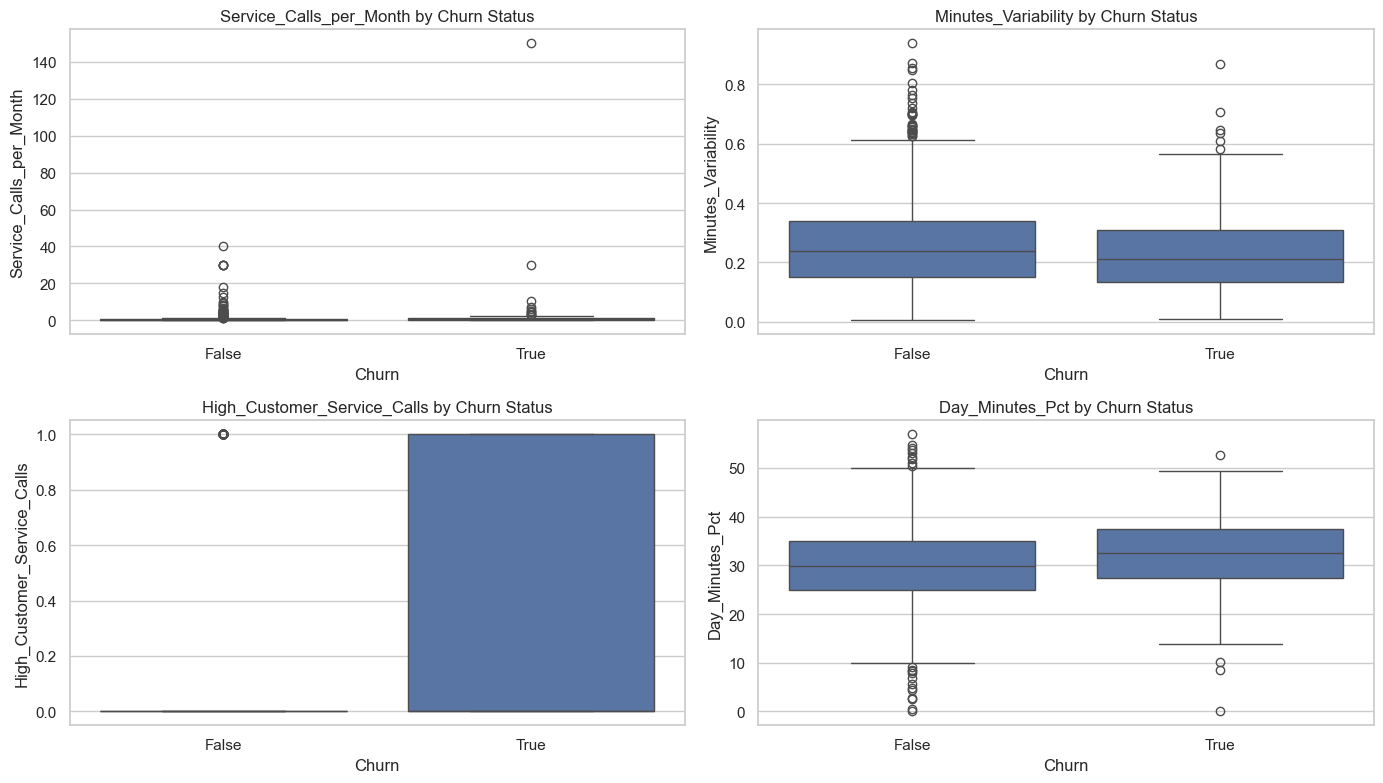


Class distribution in training data:
Churn
False    85.459662
True     14.540338
Name: proportion, dtype: float64

Handling class imbalance through model weights...
- Will use class_weight='balanced' in model training
- This assigns higher weights to minority class samples
- No resampling needed, preserving original data distribution
Effective class weights that will be used: {True: 3.4387096774193546, False: 0.5850713501646543}
Class distribution (unchanged):
Churn
False    85.459662
True     14.540338
Name: proportion, dtype: float64

Handling high-cardinality State variable...
Applying target encoding to the State variable...
Calculating churn rate by state...

Top 5 states with highest churn rate:
State
TX    0.348837
NJ    0.272727
MI    0.260870
AR    0.243243
MS    0.225000
Name: Churn, dtype: float64

Bottom 5 states with lowest churn rate:
State
OK    0.054054
HI    0.055556
NE    0.058824
AZ    0.058824
IA    0.060606
Name: Churn, dtype: float64
Mapping state churn rates to 

In [2]:
# Feature Engineering and Preprocessing for Customer Churn Prediction
# Feature engineering, preprocessing, and feature selection to prepare telecom customer data for churn prediction modeling
#
# Workflow:
#   1. Loading and exploring the raw telecom data
#   2. Creating engineered features to capture customer behavior patterns
#   3. Handling categorical features through encoding techniques
#   4. Applying preprocessing (imputation, scaling)
#   5. Feature selection to identify most predictive attributes
#   6. Preparing final datasets for model training

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
# Will use class weights to handle imbalance
import warnings
import os

# Set visualization style and figure size for consistent plotting
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
# Suppressing warnings to keep output clean
warnings.filterwarnings('ignore')

## Data loading with multiple path options for flexibility
print("Loading datasets...")

# File paths to handle different environments
relative_paths = ['data/raw/churn-bigml-80.csv', 'data/raw/churn-bigml-20.csv']
absolute_paths = [
    r"C:\Users\maze2\Customer-Churn-Prediction\data\raw\churn-bigml-80.csv",
    r"C:\Users\maze2\Customer-Churn-Prediction\data\raw\churn-bigml-20.csv"
]

# Trying to load the data, first with relative paths, then with absolute paths
try:
    # First attempt: relative paths (more portable)
    train_data = pd.read_csv(relative_paths[0])
    test_data = pd.read_csv(relative_paths[1])
    print("Successfully loaded data using relative paths.")
except FileNotFoundError:
    try:
        # Second attempt: absolute paths (specific to current environment)
        train_data = pd.read_csv(absolute_paths[0])
        test_data = pd.read_csv(absolute_paths[1])
        print("Successfully loaded data using absolute paths.")
    except FileNotFoundError:
        # Error handling if files can't be found in either location
        print("ERROR: Could not find the CSV files!")
        print(f"Tried paths: {relative_paths[0]} and {absolute_paths[0]}")
        train_data = pd.DataFrame()
        test_data = pd.DataFrame()
        
# Report data dimensions if loading was successful
if not train_data.empty and not test_data.empty:
    print(f"Training set shape: {train_data.shape}")
    print(f"Test set shape: {test_data.shape}")
else:
    print("Data loading failed.")
    # Exit early if data loading failed
    import sys
    sys.exit()

## Quick data overview to confirm everything loaded correctly
print("\nData overview:")
# Display information about data types and missing values
train_data.info()

# Check target variable type and distribution
print("\nTarget variable type:")
print(train_data['Churn'].dtype)
print("\nChurn distribution:")
print(train_data['Churn'].value_counts(normalize=True) * 100)

## Perform train-validation split before feature engineering
# Preventing data leakage when engineering features
print("\nCreating validation set...")
# Separate features (X) and target (y)
X = train_data.drop('Churn', axis=1)
y = train_data['Churn']

# Create stratified split to maintain class balance in both sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

## Feature Engineering function
print("\nEngineering features...")

def engineer_features(df):
    """
    Create meaningful derived features from the raw telecom data
    
    Args:
        df: DataFrame containing the raw features
        
    Returns:
        DataFrame with original and newly engineered features
    """
    # Create a copy so I can avoid modifying the original dataframe
    df = df.copy()
    
    # === RATIO FEATURES ===
    # Create ratios between different time periods to identify usage preferences
    # First, protect against division by zero by replacing zeros with small value (0.01)
    # Zero-value replacement is important for stable ratio calculations
    eve_minutes_safe = df['Total eve minutes'].replace(0, 0.01)  # Prevent div by zero
    night_minutes_safe = df['Total night minutes'].replace(0, 0.01)  # Prevent div by zero
    day_minutes_safe = df['Total day minutes'].replace(0, 0.01)  # Prevent div by zero
    
    # Calculate usage ratios between different time periods
    # Higher Day-to-Eve ratio means customer uses more daytime minutes relative to evening
    df['Day_to_Eve_Ratio'] = df['Total day minutes'] / eve_minutes_safe
    
    # Higher Day-to-Night ratio means customer uses more daytime minutes relative to nighttime
    df['Day_to_Night_Ratio'] = df['Total day minutes'] / night_minutes_safe
    
    # Higher Eve-to-Night ratio means customer uses more evening minutes relative to nighttime
    df['Eve_to_Night_Ratio'] = df['Total eve minutes'] / night_minutes_safe
    
    # Higher International-to-Day ratio indicates customer makes more international calls relative to local day calls
    # This can be an important churn indicator as customers with high international usage may be price-sensitive
    df['International_to_Day_Ratio'] = df['Total intl minutes'] / day_minutes_safe
    
    # === CALL DENSITY FEATURES ===
    # These measure how frequently customers make calls (calls per minute)
    # Higher density might indicate different behavior patterns
    df['Day_Calls_per_Minute'] = df['Total day calls'] / df['Total day minutes'].replace(0, 0.01)
    df['Eve_Calls_per_Minute'] = df['Total eve calls'] / df['Total eve minutes'].replace(0, 0.01)
    df['Night_Calls_per_Minute'] = df['Total night calls'] / df['Total night minutes'].replace(0, 0.01)
    df['Intl_Calls_per_Minute'] = df['Total intl calls'] / df['Total intl minutes'].replace(0, 0.01)
    
    # === PRICING FEATURES ===
    # These capture the per-minute rates being charged
    # Variations might indicate different plans or pricing tiers
    df['Day_Charge_per_Minute'] = df['Total day charge'] / df['Total day minutes'].replace(0, 0.01)
    df['Eve_Charge_per_Minute'] = df['Total eve charge'] / df['Total eve minutes'].replace(0, 0.01)
    df['Night_Charge_per_Minute'] = df['Total night charge'] / df['Total night minutes'].replace(0, 0.01)
    df['Intl_Charge_per_Minute'] = df['Total intl charge'] / df['Total intl minutes'].replace(0, 0.01)
    
    # === AGGREGATION FEATURES ===
    # Total usage across all time periods
    # These provide overall usage profile at a glance
    df['Total_Minutes'] = df['Total day minutes'] + df['Total eve minutes'] + df['Total night minutes'] + df['Total intl minutes']
    df['Total_Calls'] = df['Total day calls'] + df['Total eve calls'] + df['Total night calls'] + df['Total intl calls']
    df['Total_Charge'] = df['Total day charge'] + df['Total eve charge'] + df['Total night charge'] + df['Total intl charge']
    
    # === VARIABILITY FEATURES ===
    # Calculate coefficient of variation (CV = standard deviation / mean) to measure usage consistency
    # High variability might indicate irregular usage patterns or sporadic users
    # These customers might be less engaged with the service
    
    # Define the columns for minutes usage across different periods
    call_minutes = ['Total day minutes', 'Total eve minutes', 'Total night minutes']
    
    # Calculate standard deviation of minutes across time periods (axis=1 means row-wise)
    minutes_std = df[call_minutes].std(axis=1)
    
    # Calculate mean minutes, with zero protection
    minutes_mean = df[call_minutes].mean(axis=1).replace(0, 0.01)
    
    # Create coefficient of variation for minutes (std/mean)
    # Higher values indicate more variable/inconsistent usage patterns
    df['Minutes_Variability'] = minutes_std / minutes_mean
    
    # Repeat the same process for call counts
    call_counts = ['Total day calls', 'Total eve calls', 'Total night calls']
    calls_std = df[call_counts].std(axis=1)
    calls_mean = df[call_counts].mean(axis=1).replace(0, 0.01)
    df['Calls_Variability'] = calls_std / calls_mean
    
    # === USAGE BALANCE FEATURES ===
    # Percentage of usage in each time period
    # These capture when customers prefer to use their service
    df['Day_Minutes_Pct'] = df['Total day minutes'] / df['Total_Minutes'].replace(0, 0.01) * 100
    df['Eve_Minutes_Pct'] = df['Total eve minutes'] / df['Total_Minutes'].replace(0, 0.01) * 100
    df['Night_Minutes_Pct'] = df['Total night minutes'] / df['Total_Minutes'].replace(0, 0.01) * 100
    df['Intl_Minutes_Pct'] = df['Total intl minutes'] / df['Total_Minutes'].replace(0, 0.01) * 100
    
    # === CUSTOMER RELATIONSHIP FEATURES ===
    # Customer service intensity normalized by account length
    # Higher values might indicate problem customers
    df['Service_Calls_per_Month'] = (df['Customer service calls'] / df['Account length'] * 30).replace(np.inf, 0)
    df['Vmail_Messages_per_Month'] = (df['Number vmail messages'] / df['Account length'] * 30).replace(np.inf, 0)
    
    # === CUSTOMER FLAGS/INDICATORS ===
    # Binary indicators for plan types and risk flags
    # These directly encode important categorical attributes
    df['Has_International_Plan'] = (df['International plan'] == 'Yes').astype(int)
    df['Has_Voice_Mail_Plan'] = (df['Voice mail plan'] == 'Yes').astype(int)
    
    # Indicator for heavy customer service usage (a key churn predictor from EDA)
    df['High_Customer_Service_Calls'] = (df['Customer service calls'] > 3).astype(int)
    
    # Indicator for voice mail users vs. subscribers who don't use it
    df['Is_Active_VMail_User'] = ((df['Voice mail plan'] == 'Yes') & (df['Number vmail messages'] > 0)).astype(int)
    
    # Indicator for high international usage customers
    df['High_International_Usage'] = (df['Total intl minutes'] > df['Total intl minutes'].quantile(0.75)).astype(int)
    
    # === AREA CODE TREATMENT ===
    # Convert area code to categorical since it's not truly numerical
    df['Area_Code_Str'] = 'Area_' + df['Area code'].astype(str)
    
    return df

# Apply feature engineering to all datasets
X_train_eng = engineer_features(X_train)
X_val_eng = engineer_features(X_val)
X_test_eng = engineer_features(test_data.drop('Churn', axis=1))

# Printing newly created features
print("\nNew engineered features:")
new_features = [col for col in X_train_eng.columns if col not in X_train.columns]
print(new_features)
print(f"\nTotal features after engineering: {X_train_eng.shape[1]}")

## Visualizing some engineered features
print("\nVisualizing key engineered features by churn status...")
# Select a few important features to visualize
features_to_plot = ['Service_Calls_per_Month', 'Minutes_Variability', 
                    'High_Customer_Service_Calls', 'Day_Minutes_Pct']

# Create a 2x2 grid of boxplots showing feature distributions by churn status
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
for i, feature in enumerate(features_to_plot):
    row, col = i // 2, i % 2
    # Use box plots to show distribution differences between churned/non-churned
    sns.boxplot(x=y_train, y=X_train_eng[feature], ax=axes[row, col])
    axes[row, col].set_title(f'{feature} by Churn Status')
    axes[row, col].set_xlabel('Churn')

plt.tight_layout()
plt.show()

## Address class imbalance
# Check the current class distribution to understand the imbalance
print("\nClass distribution in training data:")
print(y_train.value_counts(normalize=True) * 100)

# Instead of using SMOTE (which requires an additional library),
# we'll use class weights in my model to handle the imbalance
print("\nHandling class imbalance through model weights...")
print("- Will use class_weight='balanced' in model training")
print("- This assigns higher weights to minority class samples")
print("- No resampling needed, preserving original data distribution")

# Using the original data without resampling
X_train_resampled = X_train_eng
y_train_resampled = y_train

# Calculate class weights for reference (inverse of class frequencies)
# These weights will be automatically calculated in models with class_weight='balanced'
class_counts = pd.Series(y_train).value_counts()
class_weights = {
    True: len(y_train) / (2 * class_counts[True]),  # Weight for minority class (True/churn)
    False: len(y_train) / (2 * class_counts[False])  # Weight for majority class (False/no churn)
}
print(f"Effective class weights that will be used: {class_weights}")

# Class distribution remains unchanged since we're not resampling
print("Class distribution (unchanged):")
print(pd.Series(y_train_resampled).value_counts(normalize=True) * 100)

## Feature selection - State handling
print("\nHandling high-cardinality State variable...")
# Problem: State has 51 unique values, which would create 51 sparse columns if one-hot encoded
# Solution: Use target encoding (also called mean encoding) to replace categorical values
#           with the mean of the target variable for that category

print("Applying target encoding to the State variable...")
# Step 1: Create a temporary dataframe with State and Churn columns from training data
# This joins the feature dataframe with the target variable
temp_df = X_train.join(y_train, how='left')

# Step 2: Calculate the average churn rate for each state
# For each state, what percentage of customers churned?
print("Calculating churn rate by state...")
state_churn_rate = temp_df.groupby('State')['Churn'].mean()

# Print top 5 and bottom 5 states by churn rate for insight
print("\nTop 5 states with highest churn rate:")
print(state_churn_rate.sort_values(ascending=False).head(5))
print("\nBottom 5 states with lowest churn rate:")
print(state_churn_rate.sort_values().head(5))

# Step 3: Map these rates to the State column in all datasets
# This replaces the state name with its average churn rate
print("Mapping state churn rates to all datasets...")
X_train_eng['State_Churn_Rate'] = X_train_eng['State'].map(state_churn_rate)
X_val_eng['State_Churn_Rate'] = X_val_eng['State'].map(state_churn_rate)
X_test_eng['State_Churn_Rate'] = X_test_eng['State'].map(state_churn_rate)

# Step 4: Handle missing values for any states that might be in validation/test but not in training
# Calculate the global average churn rate as a fallback value
global_churn_rate = y_train.mean()
print(f"Global churn rate (for missing states): {global_churn_rate:.4f}")

# Replace any NaN values with the global churn rate
print("Filling missing state churn rates with global average...")
X_train_eng['State_Churn_Rate'] = X_train_eng['State_Churn_Rate'].fillna(global_churn_rate)
X_val_eng['State_Churn_Rate'] = X_val_eng['State_Churn_Rate'].fillna(global_churn_rate)
X_test_eng['State_Churn_Rate'] = X_test_eng['State_Churn_Rate'].fillna(global_churn_rate)

# Step 5: Check if there are any missing values after filling
print("Checking for any remaining missing values in State_Churn_Rate:")
print(f"Training: {X_train_eng['State_Churn_Rate'].isna().sum()} missing values")
print(f"Validation: {X_val_eng['State_Churn_Rate'].isna().sum()} missing values")
print(f"Test: {X_test_eng['State_Churn_Rate'].isna().sum()} missing values")

## Setup preprocessing pipeline
print("\nSetting up preprocessing pipeline..")

# Identify feature types in the engineered data
# Exclude 'State' and 'Area code' as we've handled these specially
numerical_features = X_train_eng.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = [col for col in X_train_eng.select_dtypes(include=['object']).columns 
                       if col not in ['State', 'Area code']]

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features to one-hot encode: {len(categorical_features)}")

# Define preprocessing steps for numerical features using a scikit-learn Pipeline
# Pipelines chain multiple preprocessing steps in a fixed sequence
numeric_transformer = Pipeline(steps=[
    # Step 1: Handle missing values by filling with median value from training data
    # Median is robust to outliers compared to mean
    ('imputer', SimpleImputer(strategy='median')),  
    
    # Step 2: Standardize features to have mean=0 and variance=1
    # Standardization is important for:
    #  - Models sensitive to feature scales (e.g., SVM, logistic regression)
    #  - Ensuring gradient descent converges more quickly
    #  - Making feature coefficients more interpretable
    ('scaler', StandardScaler())
])

# Define preprocessing steps for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode OHE
])

# Combine preprocessing steps into a single transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

## Feature selection after preprocessing
print("\nSelecting the most informative features..")
# First need to preprocess the data before we can select features
# To ensure that categorical features are properly one-hot encoded
# and all features are properly scaled

# Step 1: Fit the preprocessor to the training data
# This learns the parameters needed for transformation (e.g., means and standard deviations for scaling)
print("Fitting preprocessor to learn transformation parameters..")
preprocessor.fit(X_train_eng)

# Step 2: Transform the training data using the fitted preprocessor
# This applies all the preprocessing steps (imputation, scaling, one-hot encoding)
print("Applying preprocessing transformations to training data..")
X_train_processed = preprocessor.transform(X_train_eng)

# Get feature names after preprocessing
def get_feature_names(column_transformer):
    """Extract feature names from the column transformer"""
    feature_names = []
    
    # Process each transformer
    for name, pipe, features in column_transformer.transformers_:
        if name == 'cat' and features:
            # For categorical features, get the one-hot encoded column names
            ohe_step = pipe.named_steps['onehot']
            for feature, categories in zip(features, ohe_step.categories_):
                for category in categories:
                    feature_names.append(f"{feature}_{category}")
        elif name == 'num':
            # For numerical features, use the original feature names
            feature_names.extend(features)
    
    return feature_names

# Get all processed feature names
processed_features = get_feature_names(preprocessor)
print(f"Features after preprocessing: {len(processed_features)}")

# Train a random forest model to calculate feature importances
# Random Forest importance scores are based on how much each feature reduces impurity
print("Using Random Forest for feature importance ranking..")
# Create a Random Forest model with:
#  - 100 trees (n_estimators=100) for stable importance estimates
#  - Fixed random_state=42 for reproducible results
#  - class_weight='balanced' to handle the class imbalance
#    (this automatically adjusts weights inversely proportional to class frequencies)
rf_model = RandomForestClassifier(
    n_estimators=100,         # Number of trees in the forest
    random_state=42,          # Seed for reproducibility
    class_weight='balanced',  # Handle class imbalance by adjusting weights
    max_depth=None,           # Allow trees to grow fully
    min_samples_split=2,      # Default value for tree splitting
    n_jobs=-1                 # Use all available CPU cores for faster training
)

# Fit the model to the processed training data to calculate feature importances
print("Training Random Forest to assess feature importance..")
rf_model.fit(X_train_processed, y_train_resampled)

# Get feature importances and sort them
feature_importances = pd.DataFrame({
    'feature': processed_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Display top 15 most important features
print("\nTop 15 most important features:")
print(feature_importances.head(15))

# Select top k features (can adjust this based on results)
top_k = 30
top_features = feature_importances.head(top_k)['feature'].tolist()

# Create a selector to extract just these features
class FeatureSelector:
    def __init__(self, feature_names, k):
        self.feature_names = feature_names
        self.k = k
        self.top_indices = None
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Get indices of top features
        if self.top_indices is None:
            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
            rf_model.fit(X, y_train_resampled)
            importances = rf_model.feature_importances_
            self.top_indices = np.argsort(importances)[-self.k:]
        
        # Return only selected features
        return X[:, self.top_indices]

# Add feature selection to the pipeline
print(f"\nAdding top {top_k} feature selection to processing pipeline...")

# Transform data with feature selection
# Apply preprocessing to all datasets
X_train_processed = preprocessor.transform(X_train_resampled)
X_val_processed = preprocessor.transform(X_val_eng)
X_test_processed = preprocessor.transform(X_test_eng)

# Create DataFrames with processed features for better interpretability
X_train_processed_df = pd.DataFrame(X_train_processed, columns=processed_features)
X_val_processed_df = pd.DataFrame(X_val_processed, columns=processed_features)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=processed_features)

# Select only the top features
X_train_processed_df = X_train_processed_df[top_features]
X_val_processed_df = X_val_processed_df[top_features]
X_test_processed_df = X_test_processed_df[top_features]

print(f"Final training set shape after feature selection: {X_train_processed_df.shape}")
print(f"Final validation set shape after feature selection: {X_val_processed_df.shape}")
print(f"Final test set shape after feature selection: {X_test_processed_df.shape}")

## Save the final processed datasets for model training and evaluation
print("\nSaving processed datasets...")
# Create the output directory if it doesn't exist
# Using os.makedirs with exist_ok=False will raise an error if directory exists
print("Checking if output directory exists..")
if not os.path.exists('data/processed'):
    print("Creating output directory: data/processed")
    os.makedirs('data/processed')
else:
    print("Output directory already exists")

try:
    # Save all processed datasets with their corresponding labels
    # We save both features (X) and target values (y) separately
    
    # Save training features and labels
    print("Saving training data (X_train_processed.csv)s")
    X_train_processed_df.to_csv('data/processed/X_train_processed.csv', index=False)
    
    print("Saving training labels (y_train_processed.csv)")
    pd.Series(y_train_resampled).to_csv('data/processed/y_train_processed.csv', index=False)
    
    # Save validation features and labels
    print("Saving validation data (X_val_processed.csv)")
    X_val_processed_df.to_csv('data/processed/X_val_processed.csv', index=False)
    
    print("Saving validation labels (y_val.csv)")
    pd.Series(y_val).to_csv('data/processed/y_val.csv', index=False)
    
    # Save test features and labels
    print("Saving test data (X_test_processed.csv)")
    X_test_processed_df.to_csv('data/processed/X_test_processed.csv', index=False)
    
    print("Saving test labels (y_test.csv)")
    test_data['Churn'].to_csv('data/processed/y_test.csv', index=False)
    
    print("All datasets saved successfully!")
except Exception as e:
    # Catch and report any errors during the saving process
    print(f"Error saving data: {e}")
    print("Please check file paths and permissions")

print("\nFeature engineering and preprocessing complete!")